In [13]:
import os
import json
import rasterio
import itertools
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

from rasterio.windows import from_bounds
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, PredictionErrorDisplay, root_mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, TransformerMixin
from datetime import datetime

EXPERIMENT_NAME = "D2_multi_img"
MODEL = "lightgbm"
MAX_DEPTH = -30
MIN_DEPTH = 0

D2_BAND_RATIOS = [
    ('Band_502', 'Band_569'),
    ('Band_489', 'Band_569'),
    ('Band_519', 'Band_569'),
    ('Band_502', 'Band_549'),
    ('Band_489', 'Band_549'),
    ('Band_569', 'Band_690'),
    ('Band_569', 'Band_832'),
    ('Band_584', 'Band_690'),
    ('Band_569', 'Band_734'),
    ('Band_569', 'Band_721'),
]

D3_BAND_RATIOS = [
    ('Band_503', 'Band_569'),
    ('Band_490', 'Band_569'),
    ('Band_519', 'Band_569'),
    ('Band_503', 'Band_550'),
    ('Band_490', 'Band_550'),
    ('Band_569', 'Band_689'),
    ('Band_569', 'Band_832'),
    ('Band_585', 'Band_689'),
    ('Band_569', 'Band_734'),
    ('Band_569', 'Band_722'),
]

wyv_palette_values = [
    "#3b26f9",
    "#ff4848",
    "#F4037B",
    "#322c56",
    "#000000",
]
wyv_palette = sns.color_palette(wyv_palette_values, len(wyv_palette_values))

In [14]:
class StumpfFeatureEngineering(BaseEstimator, TransformerMixin):
    blue_wavelength = 489
    green_wavelength = 550
    red_wavelength = 660

    def __init__(self, band_names):
        self.band_names = band_names

        # Splits "Band_XXX" into integer wavelengths
        self.wavelengths = [
            int(x.split("_")[-1]) for x in band_names
        ]

        self.offsets = [0, 0, 0]  # Offsets for blue, green, red bands
        self.matching_bands = [
            self.__find_nearest_wavelength(x, self.wavelengths)
            for x in [self.blue_wavelength, self.green_wavelength, self.red_wavelength]
        ]
        self.matching_idxs = [self.wavelengths.index(x) for x in self.matching_bands]

    def __find_nearest_wavelength(self, target_wavelength: int, wavelengths: list[int]) -> int:
        """Finds the nearest matching wavelength in a list of wavelengths.

        Args:
            target_wavelength (int): Target wavelength to match, in nanometers.
            wavelengths (list[int]): List of available wavelengths, in nanometers.

        Returns:
            int: Closest matching wavelength from the list.
        """
        array = np.asarray(wavelengths)
        idx = (np.abs(array - target_wavelength)).argmin()
        return array[idx]

    def fit(self, X, y=None):
        self.offsets = [
            np.nanmin(X[self.band_names[idx]])
            for idx in self.matching_idxs
        ]
        return self

    def transform(self, X):
        np.seterr(divide='ignore', invalid='ignore')  # Ignore division by zero warnings
        for name, (idx_1, idx_2) in [
            ("stumpf_blue_green", (0, 1)),
            ("stumpf_blue_red", (0, 2)),
            ("stumpf_green_red", (1, 2)),
        ]:
            # First, calculate stumpf ratio
            X[name] = (
                np.log(
                    X[self.band_names[self.matching_idxs[idx_1]]] +
                    self.offsets[idx_1]
                ) / np.log(
                    X[self.band_names[self.matching_idxs[idx_2]]] +
                    self.offsets[idx_2]
                )
            )
            # Then, let's replace any NaN values with 0
            X[name].fillna(0, inplace=True)
        return X
    
class SimpleRatioFeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self, band_names, band_ratios):
        self.band_names = band_names
        self.band_ratios = band_ratios

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for band_1, band_2 in self.band_ratios:
            X[f"sr_{band_1}_{band_2}"] = X[band_1] / X[band_2]
        return X
    
class NormalizedDifferenceFeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self, band_names, band_ratios):
        self.band_names = band_names
        self.band_ratios = band_ratios

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for band_1, band_2 in self.band_ratios:
            X[f"nd_{band_1}_{band_2}"] = (
                (X[band_1] - X[band_2]) /
                (X[band_1] + X[band_2])
            )
        return X

In [15]:
def process_arrays(image_arr, label_arr, filter_depth = True, bands=[], ratios=[]):
    # Flatten/reshape
    img_shp = image_arr.shape
    image_reshaped = image_arr.reshape((img_shp[0], img_shp[1] * img_shp[2]))
    label_reshaped = label_arr.reshape((1, img_shp[1] * img_shp[2]))

    # Add feature engineering
    calc_ratios, extra_feat_names = [], []
    if len(ratios) > 0:
        for band_0, band_1 in ratios:
            calc_ratios.append(image_reshaped[bands.index(band_0)] / image_reshaped[bands.index(band_1)])
            extra_feat_names.append(f"ratio_{band_0}_{band_1}")
        image_reshaped = np.append(image_reshaped, np.array(calc_ratios), axis=0)

    # Append labels to image array
    ds = np.append(image_reshaped, label_reshaped, axis=0)

    # Filter for depths greater than -50 (removes NaNs) and less than 0 (removes above water values)
    if filter_depth:
        filtered_ds = ds[:, (ds[-1] > MAX_DEPTH) & (ds[-1] < MIN_DEPTH) & (ds[0] > -100)]
        filtered_ds = np.swapaxes(filtered_ds, 0, -1)
        return filtered_ds, extra_feat_names
    else:
        return np.swapaxes(ds, 0, -1), extra_feat_names
    

def assess_model_performance(experiment_name, y_test, test_preds, y_val, val_preds) -> dict:
    return {
        "experiment": experiment_name,
        "test": {
            "samples": len(test_preds),
            "r2": r2_score(y_test, test_preds),
            "rmse": root_mean_squared_error(y_test, test_preds),
            "mae": mean_absolute_error(y_test, test_preds),
            "<5m": {
                "samples": len(test_preds[y_test > -5]),
                "r2": r2_score(y_test[y_test > -5], test_preds[y_test > -5]),
                "rmse": root_mean_squared_error(y_test[y_test > -5], test_preds[y_test > -5]),
                "mae": mean_absolute_error(y_test[y_test > -5], test_preds[y_test > -5]),
            },
            "<10m": {
                "samples": len(test_preds[y_test > -10]),
                "r2": r2_score(y_test[y_test > -10], test_preds[y_test > -10]),
                "rmse": root_mean_squared_error(y_test[y_test > -10], test_preds[y_test > -10]),
                "mae": mean_absolute_error(y_test[y_test > -10], test_preds[y_test > -10]),
            },
            "<20m": {
                "samples": len(test_preds[y_test > -20]),
                "r2": r2_score(y_test[y_test > -20], test_preds[y_test > -20]),
                "rmse": root_mean_squared_error(y_test[y_test > -20], test_preds[y_test > -20]),
                "mae": mean_absolute_error(y_test[y_test > -20], test_preds[y_test > -20]),
            },
            ">20m": {
                "samples": len(test_preds[test_preds < -20]),
                "r2": r2_score(y_test[test_preds < -20], test_preds[test_preds < -20]),
                "rmse": root_mean_squared_error(y_test[test_preds < -20], test_preds[test_preds < -20]),
                "mae": mean_absolute_error(y_test[test_preds < -20], test_preds[test_preds < -20]),
            }
        },
        "validation": {
            "samples": len(val_preds),
            "r2": r2_score(y_val, val_preds),
            "rmse": root_mean_squared_error(y_val, val_preds),
            "mae": mean_absolute_error(y_val, val_preds),
            "<5m": {
                "samples": len(val_preds[y_val > -5]),
                "r2": r2_score(y_val[y_val > -5], val_preds[y_val > -5]),
                "rmse": root_mean_squared_error(y_val[y_val > -5], val_preds[y_val > -5]),
                "mae": mean_absolute_error(y_val[y_val > -5], val_preds[y_val > -5]),
            },
            "<10m": {
                "samples": len(val_preds[y_val > -10]),
                "r2": r2_score(y_val[y_val > -10], val_preds[y_val > -10]),
                "rmse": root_mean_squared_error(y_val[y_val > -10], val_preds[y_val > -10]),
                "mae": mean_absolute_error(y_val[y_val > -10], val_preds[y_val > -10]),
            },
            "<20m": {
                "samples": len(val_preds[y_val > -20]),
                "r2": r2_score(y_val[y_val > -20], val_preds[y_val > -20]),
                "rmse": root_mean_squared_error(y_val[y_val > -20], val_preds[y_val > -20]),
                "mae": mean_absolute_error(y_val[y_val > -20], val_preds[y_val > -20]),
            },
            ">20m": {
                "samples": len(val_preds[y_val < -20]),
                "r2": r2_score(y_val[y_val < -20], val_preds[y_val < -20]),
                "rmse": root_mean_squared_error(y_val[y_val < -20], val_preds[y_val < -20]),
                "mae": mean_absolute_error(y_val[y_val < -20], val_preds[y_val < -20]),
            }
        }
    }

# First, let's load in our image array for training
train_images = [
    {
        "aoi_path": "../data/aois/wyvern_dragonette-002_20250203T005242_1eaa2a96_multi_img.geojson",
        "image_path": "../data/datasets/wyvern_dragonette-002_20250203T005242_1eaa2a96.tiff",
        "labels_path": "../data/datasets/wyvern_dragonette-002_20250203T005242_1eaa2a96_ground_truth.tif",
        "ratios": D2_BAND_RATIOS,
    },
    # {
    #     "aoi_path": "../data/aois/wyvern_dragonette-003_20250508T203730_3cb1306b_multi_img.geojson",
    #     "image_path": "../data/datasets/wyvern_dragonette-003_20250508T203730_3cb1306b.tiff",
    #     "labels_path": "../data/datasets/wyvern_dragonette-003_20250508T203730_3cb1306b_ground_truth.tif",
    #     "ratios": D3_BAND_RATIOS,
    # },
    {
        "aoi_path": "../data/aois/wyvern_dragonette-003_20241206T203812_64e116d6_multi_img.geojson",
        "image_path": "../data/datasets/wyvern_dragonette-003_20241206T203812_64e116d6.tiff",
        "labels_path": "../data/datasets/wyvern_dragonette-003_20241206T203812_64e116d6_ground_truth.tif",
        "ratios": D3_BAND_RATIOS,
    },
]

s2_train_images = [
    {
        "aoi_path": "../data/aois/wyvern_dragonette-002_20250203T005242_1eaa2a96_multi_img.geojson",
        "image_path": "../data/datasets/S2B_MSIL2A_20250102T211919_R100_T04QFJ_20250103T004642.tiff",
        "labels_path": "../data/datasets/S2B_MSIL2A_20250102T211919_R100_T04QFJ_20250103T004642_ground_truth.tif"
    },
    {
        "aoi_path": "../data/aois/wyvern_dragonette-003_20241206T203812_64e116d6_multi_img.geojson",
        "image_path": "../data/datasets/S2A_MSIL2A_20241205T210921_R057_T04QGJ_20241205T231445.tiff",
        "labels_path": "../data/datasets/S2A_MSIL2A_20241205T210921_R057_T04QGJ_20241205T231445_ground_truth.tif"
    },
]

VAL_AOI = "../data/aois/wyvern_dragonette-002_20250225T004037_4788dc6b_multi_img.geojson"
VAL_FILE = "../data/datasets/wyvern_dragonette-002_20250225T004037_4788dc6b.tiff"
VAL_LABELS_FILE = "../data/datasets/wyvern_dragonette-002_20250225T004037_4788dc6b_ground_truth.tif"

S2_VAL_AOI = "../data/aois/wyvern_dragonette-002_20250225T004037_4788dc6b_multi_img.geojson"
S2_VAL_FILE = "../data/datasets/S2B_MSIL2A_20250228T210929_R057_T04QGJ_20250228T230046.tiff"
S2_VAL_LABELS_FILE = "../data/datasets/S2B_MSIL2A_20250228T210929_R057_T04QGJ_20250228T230046_ground_truth.tif"

In [16]:
loaded_datasets = []
extra_cols = []
for train_img in s2_train_images:
    print(f"Loading: {train_img['aoi_path'].split('/')[2]}")
    aoi_df = gpd.read_file(train_img["aoi_path"])
    image_file = rasterio.open(train_img["image_path"])
    labels_file = rasterio.open(train_img["labels_path"])

    print("Generating windows")
    img_window = from_bounds(*aoi_df.total_bounds, transform=image_file.transform)
    label_window = from_bounds(*aoi_df.total_bounds, transform=labels_file.transform)

    print("Reading in arrays!")
    img_arr = image_file.read(window=img_window)
    label_arr = labels_file.read(window=label_window)

    print("Processing array!")
    proc_arr, extra_cols = process_arrays(img_arr, label_arr)
    extra_cols = extra_cols
    loaded_datasets.append(proc_arr)

print("Loading validation set!")
val_aoi_df = gpd.read_file(S2_VAL_AOI)
val_image_file = rasterio.open(S2_VAL_FILE)
val_labels_file = rasterio.open(S2_VAL_LABELS_FILE)

print("Generating val windows!")
val_img_window = from_bounds(*val_aoi_df.total_bounds, transform=val_image_file.transform)
val_label_window = from_bounds(*val_aoi_df.total_bounds, transform=val_labels_file.transform)

print("Loading val arrays!")
val_arr = val_image_file.read(window=val_img_window)
val_label_arr = val_labels_file.read(window=val_label_window)
print(f"Val image shape: {val_arr.shape}; Labels shape: {val_label_arr.shape}")

# Now we have to concatenate our image arrays for training.
filtered_train_test_ds = np.concatenate(loaded_datasets)

# Train and test the model
X_train, X_test, y_train, y_test = train_test_split(
    filtered_train_test_ds[:, 0:-1],
    filtered_train_test_ds[:, -1],
    random_state=0
)

pipe = lgb.LGBMRegressor()

# Train model
pipe.fit(filtered_train_test_ds[:, 0:-1], filtered_train_test_ds[:, -1])

# Score model
pipe.score(X_test, y_test)
test_preds = pipe.predict(X_test)

# Now lets do the same for our validation set
val_ds, extra_cols = process_arrays(
    val_arr,
    val_label_arr,
)
val_results = pipe.predict(val_ds[:, 0:-1])

perf_dict_s2 = assess_model_performance(
    experiment_name="Sentinel-2 Multi-Image Experiment",
    y_test=y_test,
    test_preds=test_preds,
    y_val=val_ds[:, -1],
    val_preds=val_results
)
perf_dict_s2

Loading: aois
Generating windows
Reading in arrays!
Processing array!
Loading: aois
Generating windows
Reading in arrays!
Processing array!
Loading validation set!
Generating val windows!
Loading val arrays!
Val image shape: (12, 504, 733); Labels shape: (1, 504, 733)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 535054, number of used features: 12
[LightGBM] [Info] Start training from score -11.623013


/opt/homebrew/Caskroom/miniforge/base/envs/wyv_bathy_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/wyv_bathy_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/wyv_bathy_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


{'experiment': 'Sentinel-2 Multi-Image Experiment',
 'test': {'samples': 133764,
  'r2': 0.9593983291364843,
  'rmse': 1.6072284080368895,
  'mae': 1.0833099213828343,
  '<5m': {'samples': 40655,
   'r2': 0.36030504930152507,
   'rmse': 1.039749889027743,
   'mae': 0.6661583871341017},
  '<10m': {'samples': 59294,
   'r2': 0.8310784173401187,
   'rmse': 1.117169989863496,
   'mae': 0.7405887888036053},
  '<20m': {'samples': 111661,
   'r2': 0.9528246423876923,
   'rmse': 1.3698023461279565,
   'mae': 0.9214412637809934},
  '>20m': {'samples': 22746,
   'r2': 0.43652436730377375,
   'rmse': 2.433909354710555,
   'mae': 1.9255497098916847}},
 'validation': {'samples': 122088,
  'r2': 0.8498341354248854,
  'rmse': 3.07628473047923,
  'mae': 2.0435602548613443,
  '<5m': {'samples': 71254,
   'r2': -1.4981283192968808,
   'rmse': 1.5770819364866242,
   'mae': 1.0307854888442205},
  '<10m': {'samples': 91043,
   'r2': 0.30970366546009487,
   'rmse': 2.0543028147194264,
   'mae': 1.3194354313

In [17]:
loaded_datasets = []
extra_cols = []
for train_img in train_images:
    print(f"Loading: {train_img['aoi_path'].split('/')[2]}")
    aoi_df = gpd.read_file(train_img["aoi_path"])
    image_file = rasterio.open(train_img["image_path"])
    labels_file = rasterio.open(train_img["labels_path"])

    print("Generating windows")
    img_window = from_bounds(*aoi_df.total_bounds, transform=image_file.transform)
    label_window = from_bounds(*aoi_df.total_bounds, transform=labels_file.transform)

    print("Reading in arrays!")
    img_arr = image_file.read(window=img_window)
    label_arr = labels_file.read(window=label_window)

    print("Processing array!")
    proc_arr, extra_cols = process_arrays(img_arr, label_arr, bands=list(image_file.descriptions), ratios=train_img["ratios"])
    extra_cols = extra_cols
    loaded_datasets.append(proc_arr)

print("Loading validation set!")
val_aoi_df = gpd.read_file(VAL_AOI)
wyv_val_image_file = rasterio.open(VAL_FILE)
val_labels_file = rasterio.open(VAL_LABELS_FILE)

print("Generating val windows!")
val_img_window = from_bounds(*val_aoi_df.total_bounds, transform=wyv_val_image_file.transform)
val_label_window = from_bounds(*val_aoi_df.total_bounds, transform=val_labels_file.transform)

print("Loading val arrays!")
val_arr = wyv_val_image_file.read(window=val_img_window)
val_label_arr = val_labels_file.read(window=val_label_window)
print(f"Val image shape: {val_arr.shape}; Labels shape: {val_label_arr.shape}")

# Now we have to concatenate our image arrays for training.
filtered_train_test_ds = np.concatenate(loaded_datasets)

# Train and test the model
X_train, X_test, y_train, y_test = train_test_split(
    filtered_train_test_ds[:, 0:-1],
    filtered_train_test_ds[:, -1],
    random_state=0
)

wyv_model = lgb.LGBMRegressor()

# Train model
wyv_model.fit(filtered_train_test_ds[:, 0:-1], filtered_train_test_ds[:, -1])

# Score model
wyv_model.score(X_test, y_test)
test_preds = wyv_model.predict(X_test)

# Now lets do the same for our validation set
wyv_val_ds, wyv_extra_cols = process_arrays(
    val_arr,
    val_label_arr,
    bands=wyv_val_image_file.descriptions,
    ratios=D2_BAND_RATIOS
)
wyv_val_results = wyv_model.predict(wyv_val_ds[:, 0:-1])

perf_dict_wyv = assess_model_performance(
    experiment_name="Dragonette-002 Multi-Image Experiment",
    y_test=y_test,
    test_preds=test_preds,
    y_val=wyv_val_ds[:, -1],
    val_preds=wyv_val_results
)
perf_dict_wyv

Loading: aois
Generating windows
Reading in arrays!
Processing array!
Loading: aois
Generating windows
Reading in arrays!
Processing array!
Loading validation set!
Generating val windows!
Loading val arrays!
Val image shape: (31, 1008, 1467); Labels shape: (1, 1008, 1467)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10455
[LightGBM] [Info] Number of data points in the train set: 2079388, number of used features: 41
[LightGBM] [Info] Start training from score -11.647695


/opt/homebrew/Caskroom/miniforge/base/envs/wyv_bathy_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/wyv_bathy_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/wyv_bathy_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


{'experiment': 'Dragonette-002 Multi-Image Experiment',
 'test': {'samples': 519847,
  'r2': 0.9614212798820762,
  'rmse': 1.5546475763888594,
  'mae': 1.0600961989869504,
  '<5m': {'samples': 156266,
   'r2': 0.4767895988876487,
   'rmse': 0.9382742856092026,
   'mae': 0.6001723520317276},
  '<10m': {'samples': 227765,
   'r2': 0.8365680022501879,
   'rmse': 1.103002772294142,
   'mae': 0.7314578631876626},
  '<20m': {'samples': 435125,
   'r2': 0.9539540669528004,
   'rmse': 1.3535421373302696,
   'mae': 0.9146907797718885},
  '>20m': {'samples': 87136,
   'r2': 0.467267286467395,
   'rmse': 2.3161512548095735,
   'mae': 1.8246032080739911}},
 'validation': {'samples': 488626,
  'r2': 0.4780719055224899,
  'rmse': 5.741737667229357,
  'mae': 3.5490819263702593,
  '<5m': {'samples': 285058,
   'r2': -4.7439956356455175,
   'rmse': 2.3894586345327236,
   'mae': 1.395198576407695},
  '<10m': {'samples': 364246,
   'r2': -1.6081807531609407,
   'rmse': 3.9926061072221755,
   'mae': 2.268

In [18]:
for i, ds in enumerate(loaded_datasets):
    plt.hist(ds[:, 10], bins=20, range=(0, 0.2))

In [19]:
val_img_arr, extra_cols = process_arrays(
    val_arr,
    val_label_arr,
    filter_depth=False,
    bands=wyv_val_image_file.descriptions,
    ratios=D2_BAND_RATIOS
)

empty_arr = np.empty((val_label_arr.shape[1], val_label_arr.shape[2]))
empty_arr[:] = np.nan

val_img_preds = wyv_model.predict(val_img_arr[:, 0:-1])
val_img_preds_reshaped = val_img_preds.reshape((val_label_arr.shape[1],val_label_arr.shape[2]))
val_img_preds_filt = np.where((val_label_arr < 0) & (val_label_arr > -30), val_img_preds_reshaped, empty_arr)
val_img_actual = np.where((val_label_arr < 0) & (val_label_arr > -30), val_label_arr, empty_arr)

/opt/homebrew/Caskroom/miniforge/base/envs/wyv_bathy_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


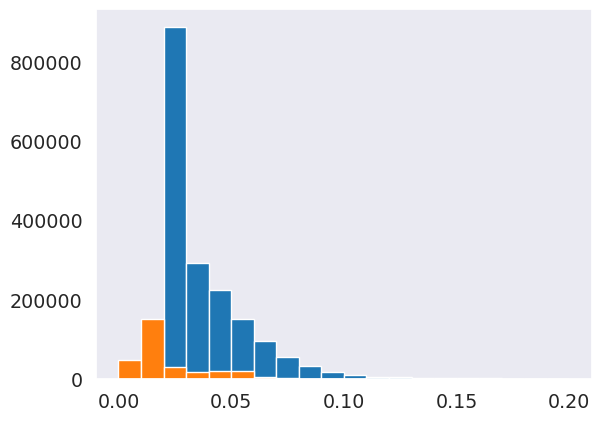

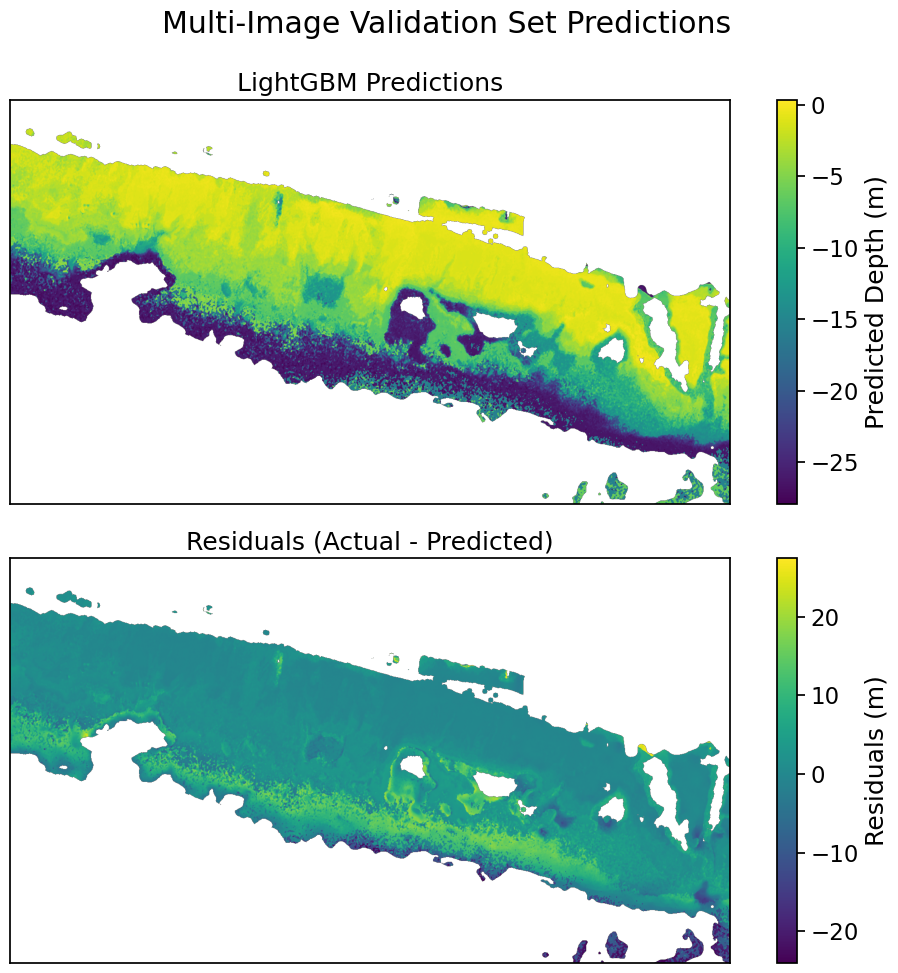

In [20]:
import seaborn as sns

sns.reset_defaults()
sns.set_context("notebook", font_scale=1.5)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))
preds_img = axs[0].imshow(val_img_preds_filt[0, 0:825, :])
cbar = plt.colorbar(preds_img, ax=axs[0], label="Predicted Depth (m)")
axs[0].set_title("LightGBM Predictions")
#axs[0].set_aspect('auto')
axs[0].set_xticks([])
axs[0].set_yticks([])

resid_img = axs[1].imshow((val_img_actual[0] - val_img_preds_filt[0])[0:825, :])
cbar = plt.colorbar(resid_img, ax=axs[1], label="Residuals (m)")
axs[1].set_title("Residuals (Actual - Predicted)")
#axs[1].set_aspect('auto')
axs[1].set_xticks([])
axs[1].set_yticks([])
plt.suptitle("Multi-Image Validation Set Predictions")
plt.tight_layout()

plt.savefig("drag002-predictions-vis-multi-img.jpg", dpi=300)
plt.show()

In [21]:
perf_dict = assess_model_performance(
    experiment_name="Dragonette-002 Multi-Image Experiment",
    y_test=y_test,
    test_preds=test_preds,
    y_val=val_ds[:, -1],
    val_preds=val_results
)

In [22]:
def flatten_json(nested_json, exclude=['']):
    """Flatten json object with nested keys into a single level.
        Args:
            nested_json: A nested json object.
            exclude: Keys to exclude from output.
        Returns:
            The flattened json object if successful, None otherwise.
    """
    out = {}

    def flatten(x, name='', exclude=exclude):
        if type(x) is dict:
            for a in x:
                if a not in exclude: flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(nested_json)
    return out



In [23]:
import pandas as pd
import seaborn as sns

wyv_palette_values = [
    "#3b26f9",
    "#ff4848",
    "#F4037B",
    "#322c56",
    "#000000",
]
wyv_palette = sns.color_palette(wyv_palette_values, len(wyv_palette_values))
perf_dict_wyv["satellite"] = "dragonette-002"
perf_dict_s2["satellite"] = "sentinel-2"
df = pd.DataFrame.from_records([flatten_json(perf_dict_wyv), flatten_json(perf_dict_s2)])
df

,experiment,test_samples,test_r2,test_rmse,test_mae,test_<5m_samples,test_<5m_r2,test_<5m_rmse,test_<5m_mae,test_<10m_samples,...,validation_<10m_mae,validation_<20m_samples,validation_<20m_r2,validation_<20m_rmse,validation_<20m_mae,validation_>20m_samples,validation_>20m_r2,validation_>20m_rmse,validation_>20m_mae,satellite
0,Dragonette-002 Multi-Image Experiment,519847,0.961421,1.554648,1.060096,156266,0.476790,0.938274,0.600172,227765,...,2.268629,436339,-0.094172,5.156300,3.176676,52287,-8.811106,9.284942,6.656838,dragonette-002
1,Sentinel-2 Multi-Image Experiment,133764,0.959398,1.607228,1.083310,40655,0.360305,1.039750,0.666158,59294,...,1.319435,109078,0.730580,2.559082,1.714291,13010,-2.858140,5.822392,4.804210,sentinel-2


/var/folders/rg/jpb72q99503gth11wv_9p4mh0000gn/T/ipykernel_12355/2530440493.py:10: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.barplot(melt_df, x="satellite", y="mae", hue="variable", palette=wyv_palette[2:])


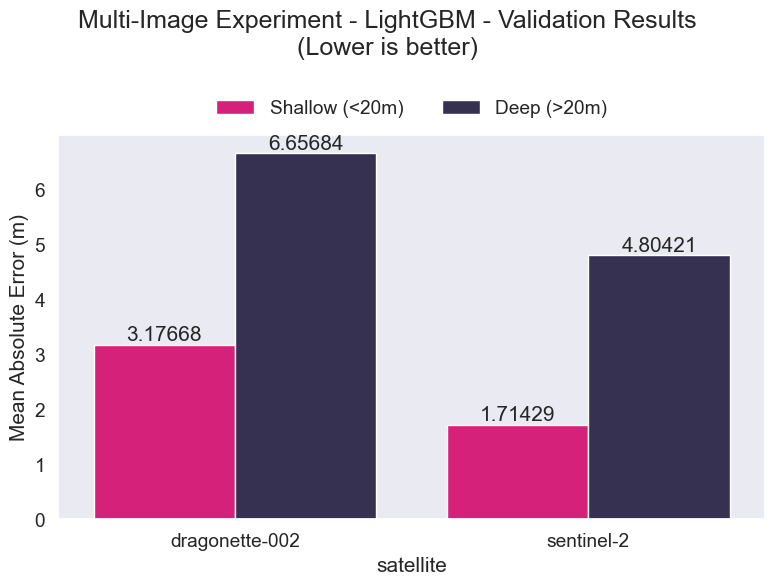

In [25]:
sat = "Dragonette-002"
model_name = "LightGBM"
sns.set_style("dark")
sns.set_context("notebook", font_scale=1.25)
filt_df = df
melt_df = filt_df.melt(id_vars=["satellite"], value_vars=["validation_<20m_mae", "validation_>20m_mae"], value_name="mae")
map_dict = {"validation_<20m_mae": "Shallow (<20m)", "validation_>20m_mae": "Deep (>20m)"}
melt_df.replace({"variable": map_dict}, inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.barplot(melt_df, x="satellite", y="mae", hue="variable", palette=wyv_palette[2:])
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)
ax.set(ylabel="Mean Absolute Error (m)")
for i in ax.containers:
    i.datavalues = np.round(i.datavalues, 2)
    ax.bar_label(i,)

plt.suptitle(f"Multi-Image Experiment - LightGBM - Validation Results\n(Lower is better)")
plt.tight_layout()
plt.savefig(f"multi_img_lightgbm_results.jpg", dpi=200)
plt.show()

In [36]:
filt_df.melt(id_vars=["satellite"], value_vars=["validation_<20m_mae", "validation_>20m_mae"], value_name="mae")

,satellite,variable,mae
0,dragonette-002,validation_<20m_mae,1.543819
1,sentinel-2,validation_<20m_mae,1.714291
2,dragonette-002,validation_>20m_mae,8.427963
3,sentinel-2,validation_>20m_mae,4.804210


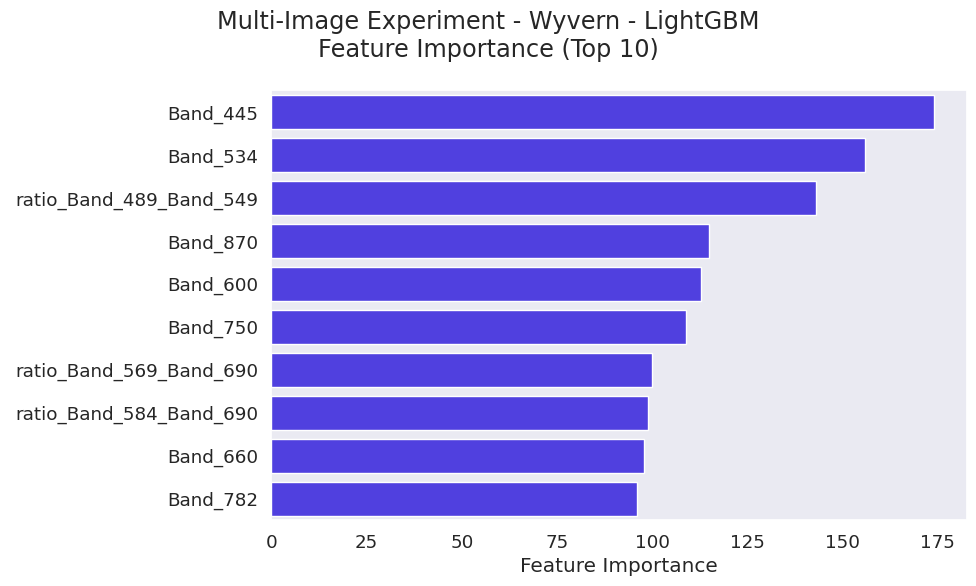

In [13]:
sns.set_style("dark")
sns.set_context("notebook", font_scale=1.2)
sns.set_palette(wyv_palette)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
feat_names = list(wyv_val_image_file.descriptions) + wyv_extra_cols
df = pd.DataFrame.from_records(zip(feat_names, wyv_model.feature_importances_), columns=["feature", "importance"])
df.sort_values("importance", ascending=False, inplace=True)

sns.barplot(df.iloc[0:10], x="importance", y="feature")
ax.set_xlabel("Feature Importance")
ax.set_ylabel(" ")
plt.suptitle(f"Multi-Image Experiment - Wyvern - LightGBM\nFeature Importance (Top 10)")
plt.tight_layout()

plt.savefig(f"multi_img_feature_importance.jpg", dpi=300)
sns.reset_defaults()
plt.show()

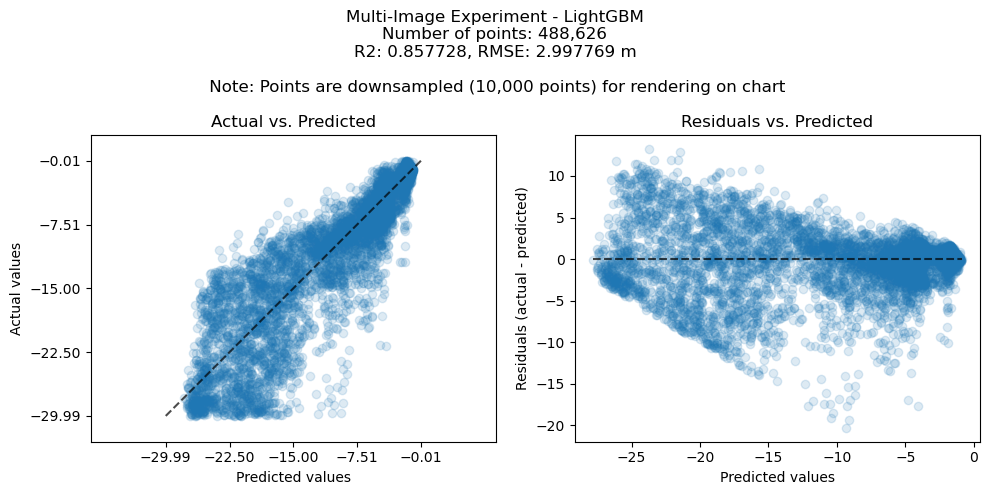

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

index = np.random.choice(wyv_val_ds[:, -1].shape[0], 10000, replace=False)  
pred_err = PredictionErrorDisplay(y_true=wyv_val_ds[:, -1][index], y_pred=wyv_val_results[index])

# Actually plot prediction error
pred_err.plot(ax=axs[0], kind="actual_vs_predicted", scatter_kwargs={"alpha": 0.15})
pred_err.plot(ax=axs[1], kind="residual_vs_predicted", scatter_kwargs={"alpha": 0.15})

r_2 = r2_score(wyv_val_ds[:, -1], wyv_val_results)
rmse = root_mean_squared_error(wyv_val_ds[:, -1], wyv_val_results)

axs[0].set_title("Actual vs. Predicted")
axs[1].set_title("Residuals vs. Predicted")
full_title = (
    f"Multi-Image Experiment - LightGBM"
    f"\nNumber of points: {wyv_val_ds[:, -1].shape[0]:,}"
    f"\nR2: {round(r_2, 6)}, "
    f"RMSE: {round(rmse, 6)} m"
)

full_title = full_title + f"\n\n Note: Points are downsampled (10,000 points) for rendering on chart"

plt.suptitle(full_title)
plt.tight_layout()
plt.show()

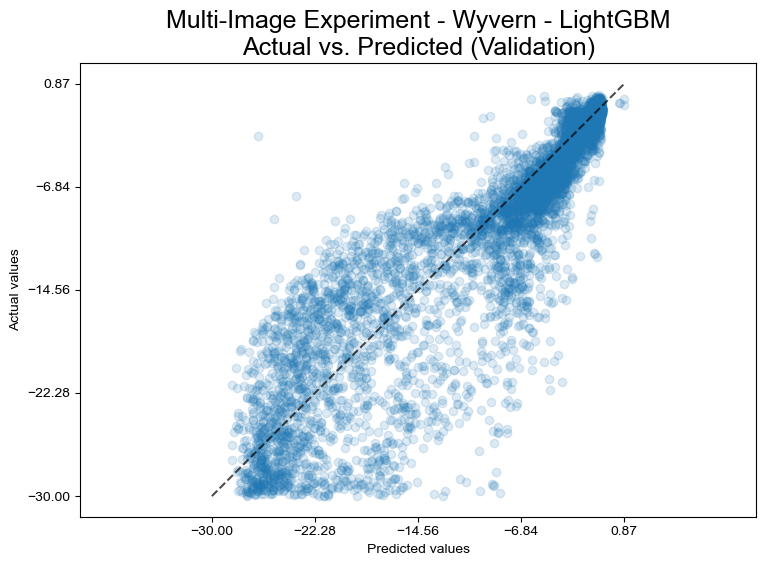

In [55]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5)
sns.set_palette(wyv_palette)
pred_err.plot(ax=ax, kind="actual_vs_predicted", scatter_kwargs={"alpha": 0.15})
plt.title("Multi-Image Experiment - Wyvern - LightGBM\nActual vs. Predicted (Validation)")
plt.tight_layout()
plt.savefig("multi_img_act_pred.jpg", dpi=300)
plt.show()

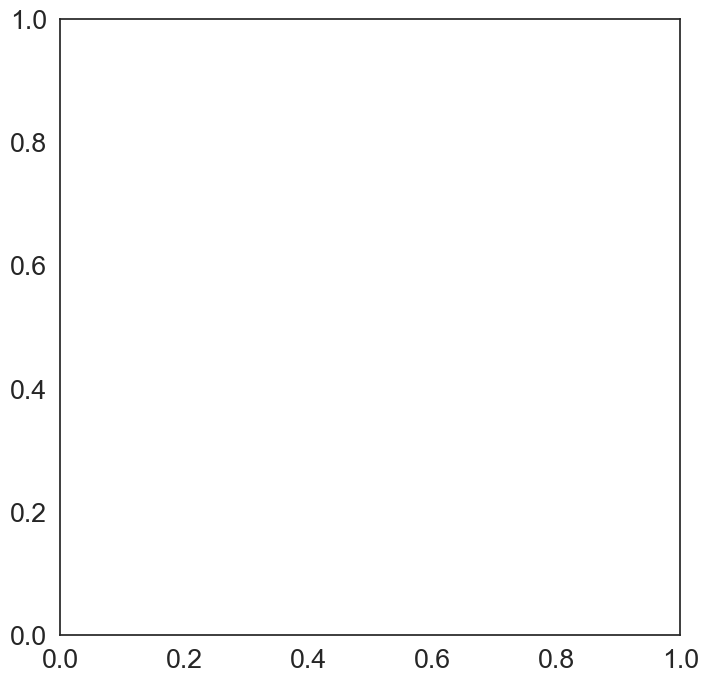

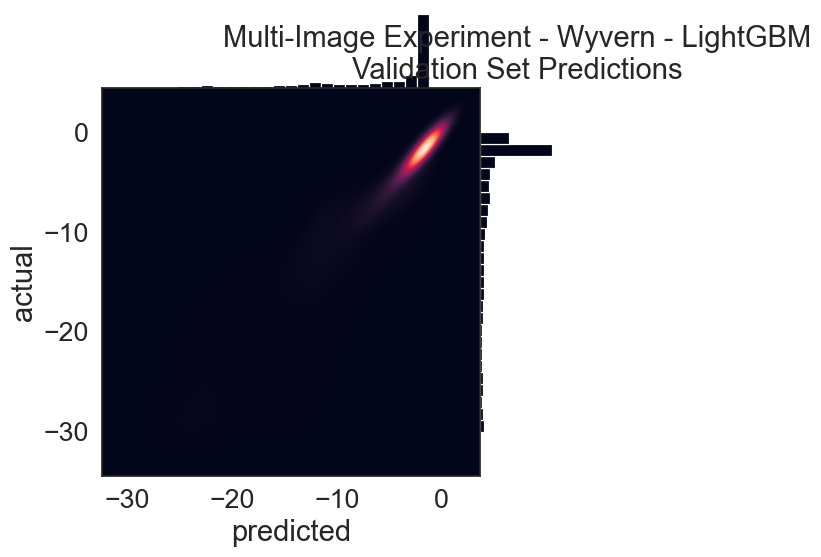

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.set_style("white")
sns.set_context("notebook", font_scale=1.75)
sns.set_palette(wyv_palette)
avp_df = pd.DataFrame.from_records(zip(wyv_val_ds[:, -1][index], wyv_val_results[index]), columns=["actual", "predicted"])
g = sns.JointGrid(data=avp_df, x="predicted", y="actual", space=0)
g.plot_joint(sns.kdeplot, fill=True, thresh=0, levels=100, cmap="rocket")
g.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=25)
plt.title("Multi-Image Experiment - Wyvern - LightGBM\nValidation Set Predictions")
plt.show()

,0,1
0,-1.062529,-1.680177
1,-0.806539,-1.740262
2,-0.845940,-1.892918
3,-1.034219,-1.626602
4,-0.904424,-1.505380
...,...,...
431330,-29.969299,-23.504009
431331,-29.986198,-24.689096
431332,-29.984884,-24.624849
431333,-29.983631,-24.085010
